# Lapa Trainer and Tester

In [ ]:
import segmentation_models_pytorch as smp
import albumentations as albu
import scipy
import torch
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import label_test_script
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn import preprocessing
from segmentation_models_pytorch import utils
import os
from torch.utils.data import DataLoader
from sklearn.metrics import jaccard_score, f1_score
import tensorflow as tf
from torchmetrics.classification import F1Score, BinaryF1Score, MulticlassF1Score, JaccardIndex
from torchmetrics import Dice
from sklearn.preprocessing import MultiLabelBinarizer
from torchvision.utils import save_image
from PIL import Image
from skimage.transform import resize
from scipy.ndimage.filters import gaussian_filter

## Initialise Model Fleet

In [1]:
SIZEX = 128
SIZEY = 128

#Hyperparamters
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet' #pretrained weighting
ACTIVATION = "sigmoid" # softmax2d for multiclass segmentation
num_classes = 11

#DEEPLABV3+
deeplab = smp.DeepLabV3Plus(
    in_channels=3,
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=num_classes, 
    activation=ACTIVATION,
)


#UNET
unet = smp.Unet(
    in_channels=3,
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=num_classes, 
    activation=ACTIVATION,
    decoder_use_batchnorm = True,
)

fcn = smp.FPN(
    in_channels=3,
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=num_classes, 
    activation=ACTIVATION,
)

mobile = smp.Unet(
    in_channels=3,
    encoder_name="mobilenet_v2", 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=num_classes, 
    activation=ACTIVATION,
    decoder_use_batchnorm = True,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

## Preprocessing Functions

In [3]:
rgb_vals = [ 0,1,2,3,4,5,6,7,8,9,10]


def to_tensor(x, **kwargs):
    x_t = x.transpose(2, 0, 1).astype('float32')
    #print("XTSHAPE", x_t.shape)
    return x_t


def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

def get_training_augmentation():
    train_transform = [

        #albu.HorizontalFlip(p=0.5),
        albu.Rotate((-18,18)),
        albu.PadIfNeeded(min_height=SIZEY, min_width=SIZEY, always_apply=True, border_mode=0),
        #albu.RandomCrop(height=320, width=320, always_apply=True),
        albu.Perspective(p=0.5),
        albu.GaussNoise(p=0.2),
        albu.OneOf([albu.CLAHE(p=1),albu.RandomBrightness(p=1),albu.RandomGamma(p=1),],p=0.9,),
        albu.OneOf([albu.Sharpen(p=1),albu.Blur(blur_limit=3, p=1),],p=0.9,),albu.OneOf([albu.RandomContrast(p=1),albu.HueSaturationValue(p=1),],p=0.9,),
    ]

    return albu.Compose(train_transform)


def transformation_augs():
    train_transform = [
        #albu.HorizontalFlip(p=0.5),

    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(SIZEY, SIZEY)
    ]
    return albu.Compose(test_transform)

/home/nathan/miniconda3/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/nathan/miniconda3/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:1175: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


## Dataset Creation

In [ ]:
class MyDataSet(torch.utils.data.Dataset):

  #CLASSES =  ["background","facial_skin","left_brow","right_brow","left_eye","right_eye", "nose","upper_lip","inner_mouth","lower_lip","hair"]

  def __init__(self, images_dir, masks_dir, coords_dir, preprocessing=None, classes=None,augmentation=None):
    super(MyDataSet, self).__init__()
    
    # store the augmented tensors tensors
    #self._x, self._y = x,y
    self.preprocessing = preprocessing
    self.augmentation = augmentation

    self.image_ids = os.listdir(images_dir)

    self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.image_ids]
    self.masks_fps = [os.path.join(masks_dir, mask_id.replace("jpg","png")) for mask_id in self.image_ids]
    self.coords_fps = [os.path.join(coords_dir, coords_id.replace("jpg", "txt")) for coords_id in self.image_ids]

  def __len__(self):
    # a DataSet must know it size
    return len(self.images_fps)

  def __getitem__(self, i):

    image = cv2.imread(self.images_fps[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_GRAYSCALE)

    # crop to center face
    smallest_x = 99999
    smallest_y = 99999
    biggest_x = -99999
    biggest_y = -99999
    with open(self.coords_fps[i], 'rb') as f:

      contents = str(f.read()).split("\\n")
      contents = [[int(float(single.replace("\\r", "").
                             replace("'", "").replace("b", "").replace("\\x1a", "")
                             )) for single in pair.split(" ")] for pair in contents[2:-2]]
      try:
        
        #print(contents)

        contents = np.array(contents)
        for pair in contents:
          #plt.scatter((pair[0]), (pair[1]), color="red")

          if (pair[0]) < smallest_x:
            smallest_x = (pair[0])
          
          if (pair[0]) > biggest_x:
            biggest_x = (pair[0])

          if (pair[1]) < smallest_y:
            smallest_y = (pair[1])
          
          if (pair[1]) > biggest_y:
            biggest_y = (pair[1])


        crop_coords = (int(smallest_x), int(biggest_x), int(smallest_y), int(biggest_y))

        image = image[smallest_y: biggest_y, smallest_x:biggest_x]
        mask = mask[smallest_y: biggest_y, smallest_x:biggest_x]


        mask = cv2.resize(mask, (SIZEY, SIZEY))
        image = cv2.resize(image, (SIZEY, SIZEY))
        mask = np.expand_dims(mask,2)
      except:
        #item corrutpted
        return self.__getitem__(i-1)
      # smooth mask
      # mask = mask = scipy.ndimage.median_filter(mask, 5)

    # apply augmentations
    if self.augmentation:
        sample = self.augmentation(image=image, mask=mask)
        image, mask = sample['image'], sample['mask']
    
    # apply preprocessing
    if self.preprocessing:
        sample = self.preprocessing(image=image, mask=mask)
        image, mask = sample['image'], sample['mask']

    #onehot
    one_hot_Y = torch.nn.functional.one_hot(torch.tensor(mask).to(torch.int64), 11).permute(0,3,1,2).float()

    return (image, one_hot_Y.squeeze(0))


train_x_path = "/home/nathan/Documents/final_project/datasets/LaPa/train/images"
train_y_path = "/home/nathan/Documents/final_project/datasets/LaPa/train/labels"
train_coords_path = "/home/nathan/Documents/final_project/datasets/LaPa/train/landmarks"

val_x_path = "/home/nathan/Documents/final_project/datasets/LaPa/val/images"
val_y_path = "/home/nathan/Documents/final_project/datasets/LaPa/val/labels"
val_coords_path = "/home/nathan/Documents/final_project/datasets/LaPa/val/landmarks"

test_x_path = "/home/nathan/Documents/final_project/datasets/LaPa/test/images"
test_y_path = "/home/nathan/Documents/final_project/datasets/LaPa/test/labels"
test_coords_path = "/home/nathan/Documents/final_project/datasets/LaPa/test/landmarks"

train_ds = MyDataSet(train_x_path, train_y_path, train_coords_path, preprocessing=get_preprocessing(preprocessing_fn),augmentation=get_training_augmentation())
val_ds = MyDataSet(val_x_path, val_y_path, val_coords_path, preprocessing=get_preprocessing(preprocessing_fn),augmentation=get_validation_augmentation())
test_ds = MyDataSet(test_x_path, test_y_path, test_coords_path, preprocessing=get_preprocessing(preprocessing_fn),augmentation=get_validation_augmentation())

## Sanity Check

0 : (3, 128, 128) torch.Size([11, 128, 128])


/tmp/ipykernel_78886/3609109764.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)


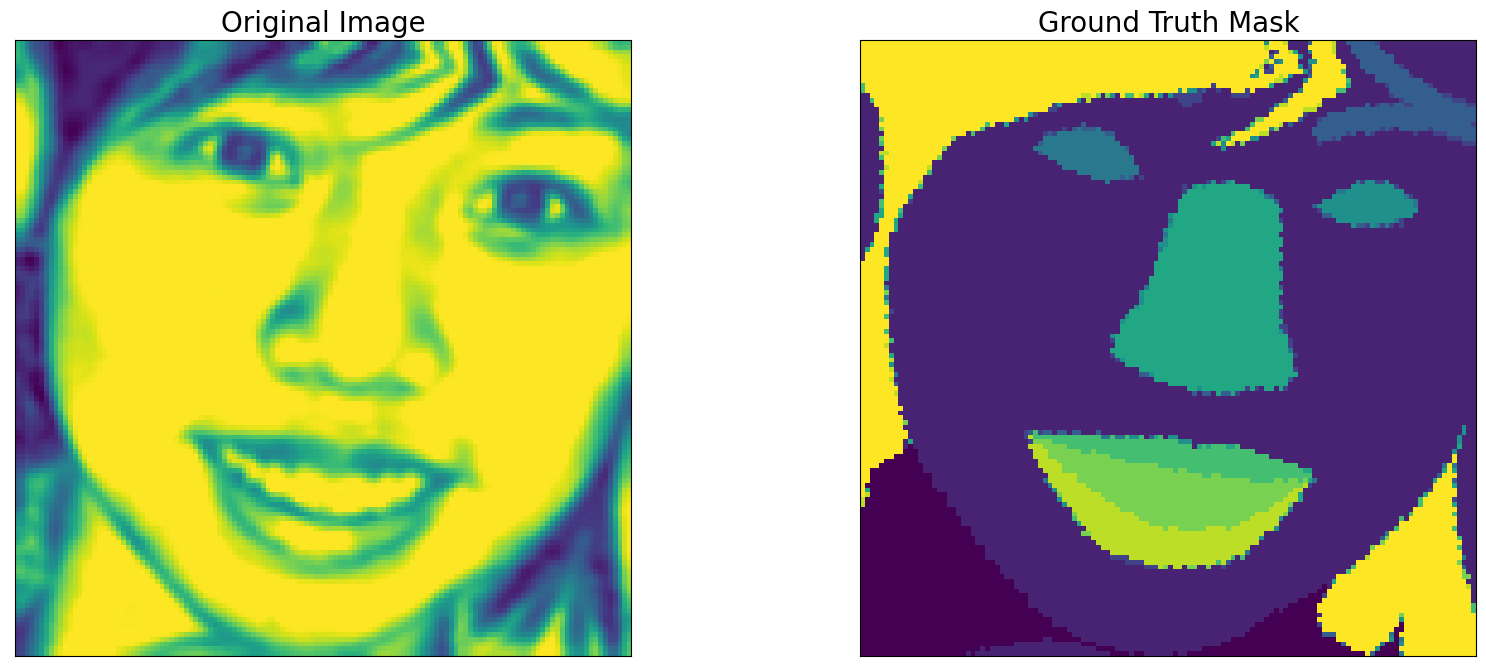

1 : (3, 128, 128) torch.Size([11, 128, 128])


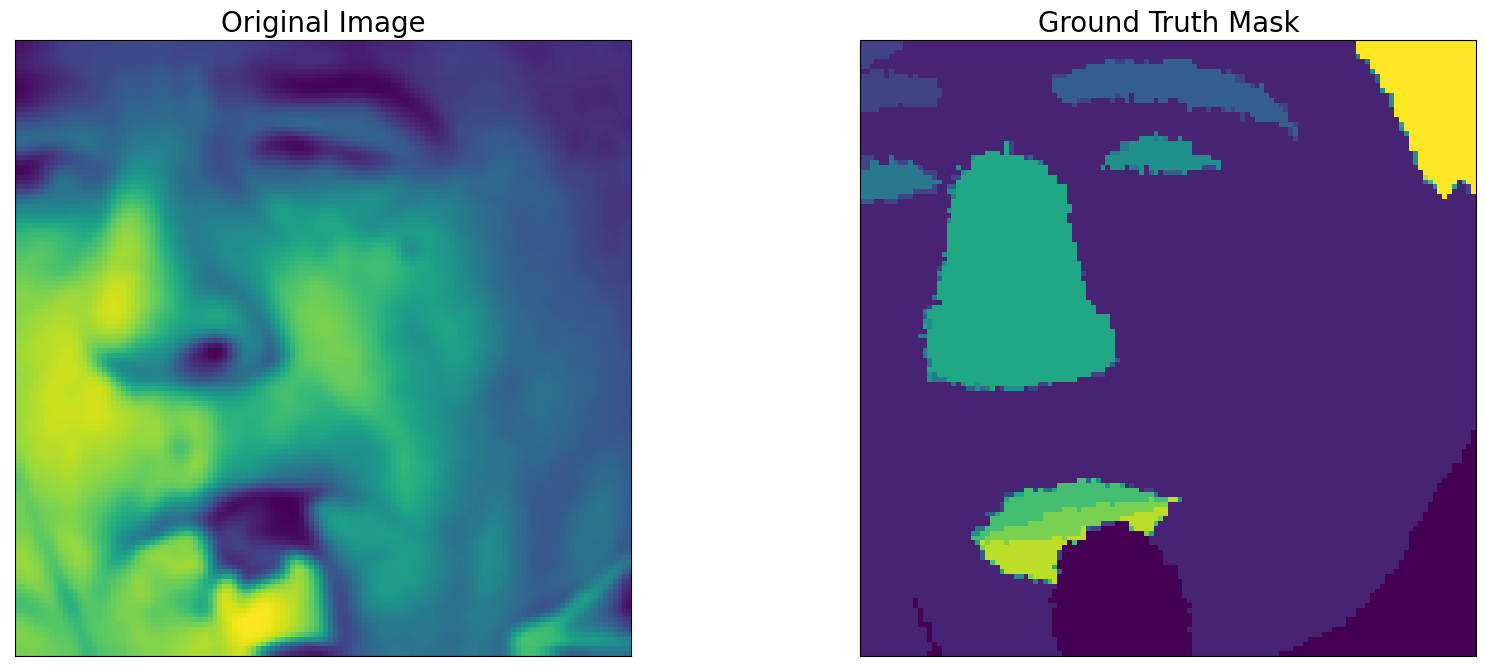

0 : (3, 128, 128) torch.Size([11, 128, 128])


/tmp/ipykernel_78886/3609109764.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)


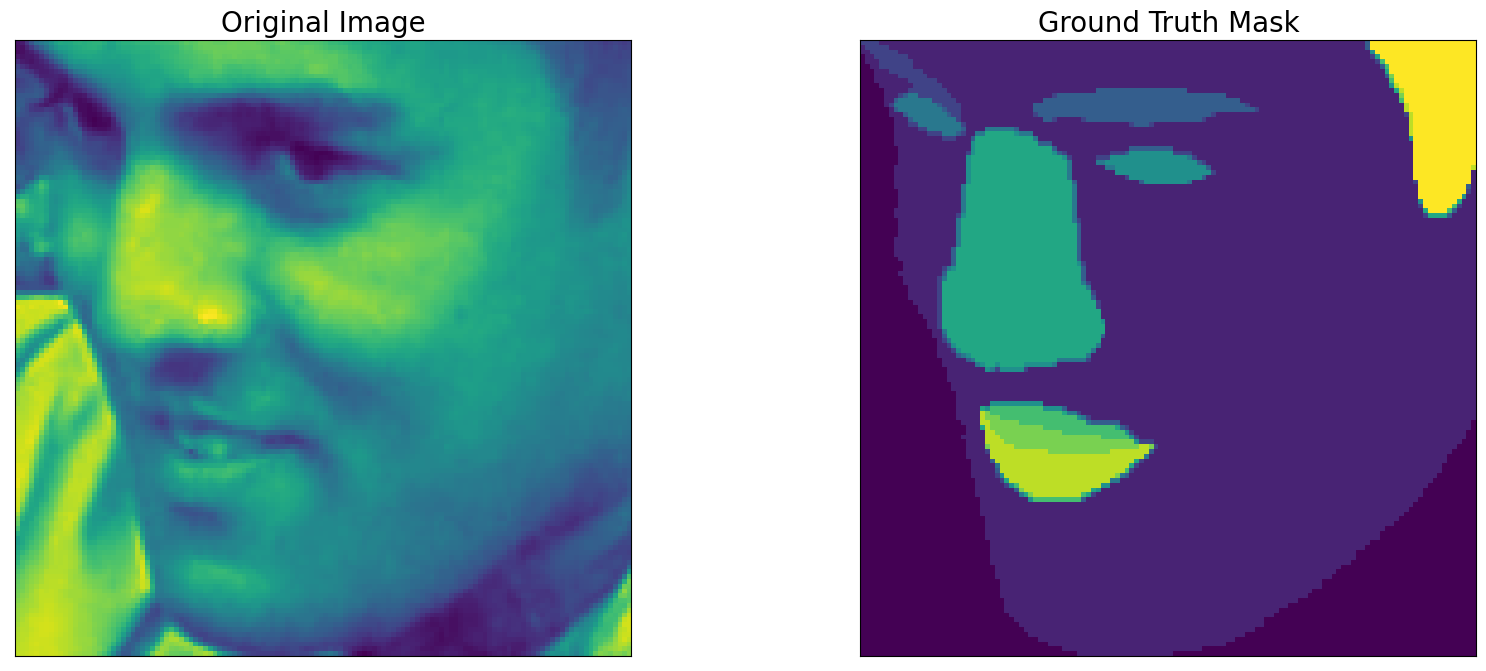

1 : (3, 128, 128) torch.Size([11, 128, 128])


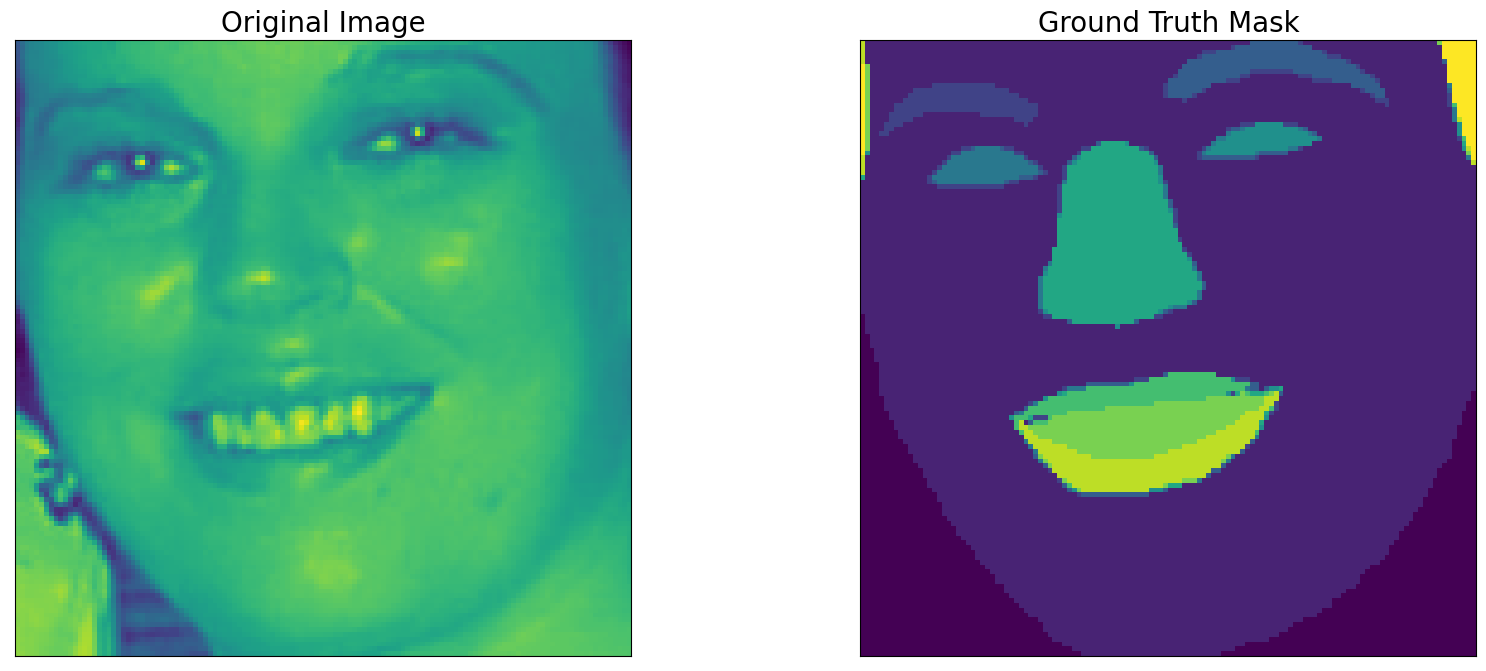

In [4]:
for x in range(1):

  image_vis, gt_mask = train_ds[x]
  print(x, ":", image_vis.shape, gt_mask.shape)

  gt_mask = label_test_script.colour_code_segmentation(label_test_script.reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)
  binary_smoothed = scipy.signal.medfilt (gt_mask, 9)

  label_test_script.visualize(
      original_image = image_vis[0,::],
      ground_truth_mask = gt_mask
  )

for x in range(1):

  image_vis, gt_mask = val_ds[x]
  print(x, ":", image_vis.shape, gt_mask.shape)

  gt_mask = label_test_script.colour_code_segmentation(label_test_script.reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)
  binary_smoothed = scipy.signal.medfilt (gt_mask, 9)

  label_test_script.visualize(
      original_image = image_vis[0,::],
      ground_truth_mask = gt_mask
  )


### Data Loader

In [5]:
# Get train and val data loaders
train_loader = DataLoader(train_ds, batch_size=24, shuffle=True, num_workers=22)
valid_loader = DataLoader(val_ds, batch_size=24, shuffle=False, num_workers=22)

757


/home/nathan/miniconda3/lib/python3.9/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 22 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Hyper Params

In [7]:
weights_per_image = []
for x, pair in enumerate(train_ds):
  mask = pair[1]
  weights = []
  for layer in np.array(mask):
    count = np.sum(layer == 1)
    if count != 0:
      weights.append(count)
    else:
      weights.append(0)
  if x == 100:
    break

  weights_per_image.append(weights)

# average down collumns
wpi_numpy = np.array(weights_per_image)
wpi_avs = wpi_numpy.mean(axis=0)

normedWeights = [1 - (x / sum(wpi_avs)) for x in wpi_avs]
normedWeights = torch.FloatTensor(normedWeights)
normedWeights

tensor([0.9019, 0.3296, 0.9823, 0.9844, 0.9884, 0.9886, 0.9196, 0.9866, 0.9857,
        0.9784, 0.9545])

In [8]:
TRAINING = True
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss = smp.utils.losses.CrossEntropyLoss(weight=normedWeights)

# define evalusation metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

## Train Model

In [9]:
import matplotlib.pyplot as plt

def train_model(model, train_loader_given, valid_loader_given, saveas, epoch):

    #clear CUDA cache
    torch.cuda.empty_cache()

    # define optimizer
    optimizer = torch.optim.NAdam(model.parameters(), lr=0.001)

    # define learning rate scheduler
    #lr_scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer)

    #define train ecpochs w/ our hyperparams
    train_epoch = smp.utils.train.TrainEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        optimizer=optimizer,
        device=DEVICE,
        verbose=True,
    )

    #define train ecpochs w/ our hyperparams
    valid_epoch = smp.utils.train.ValidEpoch(
        model, 
        loss=loss, 
        metrics=metrics, 
        device=DEVICE,
        verbose=True,
    )

    if TRAINING:

        best_iou_score = 0.0
        train_logs_list, valid_logs_list = [], []

        #Keep track of epoch BCE and IoU for graph plots
        epoch_count = []
        v_bce = []
        v_ious = []

        t_bce = []
        t_ious = []

        i = 0
        while i < epoch:
            i +=1 

            # Perform training & validation
            print('\nEpoch: {}'.format(i))
            train_logs = train_epoch.run(train_loader_given)
            valid_logs = valid_epoch.run(valid_loader_given)

            #log
            train_logs_list.append(train_logs)
            valid_logs_list.append(valid_logs)

            # Save model if a better val IoU score is obtained
            if best_iou_score < valid_logs['iou_score']:
                best_iou_score = valid_logs['iou_score']
                torch.save(model, saveas)
                print('Model saved!')

            if best_iou_score>0.8:
              optimizer.param_groups[0]['lr'] = 1e-5
              print('Decrease decoder learning rate to 1e-5!')
                
            # Append results to graphs:
            v_ious.append(valid_logs['iou_score'])
            t_ious.append(train_logs['iou_score'])
            epoch_count.append(i)
        
            # Plot graph every 2 epochs
            if i % 2 ==0:
                plt.show()
                plt.plot(epoch_count,t_ious, label="Train IoU")
                plt.plot(epoch_count,v_ious, label="Valid IoU")
                plt.legend(loc="upper left")
                plt.xlabel("Epochs")
                plt.ylabel("IoU")
                plt.show()


### Function to view train model precitions

In [14]:
def average(lst):
    return sum(lst) / len(lst)

def view_predictions(model, ds, numm_classes ):

    ious = []
    f1s = []

    #predict
    for idx in range(len(ds)):

        image, gt_mask = ds[idx]
        image = image
        image_vis = image
        image_vis = np.transpose(image_vis,(1,2,0))
        x_tensor = torch.tensor(image).to(DEVICE).unsqueeze(0)
        pred_mask = model(x_tensor)
        pred_mask = pred_mask.detach().squeeze().cpu().numpy()
        pred_mask = label_test_script.colour_code_segmentation(label_test_script.reverse_one_hot(torch.tensor(pred_mask)), rgb_vals)
        gt_mask = label_test_script.colour_code_segmentation(label_test_script.reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)
        
        #get IoU score
        """
        m = tf.keras.metrics.MeanIoU(num_classes=numm_classes)
        m.update_state(gt_mask, pred_mask)
        iou = m.result().numpy()
        #print("MEAN IoU:" , iou)
        ious.append(iou)
        """

        metric = MulticlassF1Score(num_classes=numm_classes, average=None, labels=np.unique(pred_mask) ,validate_args=True)
        #metric = JaccardIndex(task="multiclass",num_classes=numm_classes, average=None, labels=np.unique(pred_mask) ,validate_args=True)
        f1 = metric(torch.tensor(gt_mask), torch.tensor(pred_mask))
        if len(f1) == num_classes:
          f1[f1 <0.1] = np.nan
          #print(f1)
          f1s.append(np.array(f1))

        if idx == 2:
          label_test_script.visualize(
              original_image = image[0,::],
              ground_truth_mask = gt_mask,
              predicted_mask = pred_mask,
          )

    
    fs1_numpy = np.array(f1s)
    av_f1s = np.nanmean(fs1_numpy, axis=0)
    #av_f1s = fs1_numpy.mean(axis=0)
    av_f1s_av = av_f1s.mean(axis=0)

    #print ("Dataset MIoU = ", average(ious))
    print ("Dataset F1 = ", av_f1s)
    print ("Dataset F1 av = ", av_f1s_av)

/tmp/ipykernel_78886/3539481126.py:9: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


# Predict with models

In [12]:
#train_model(unet, train_loader, valid_loader, "/home/nathan/Documents/final_project/saved_models/lapa/unet.pth", 20)
#train_model(fcn, train_loader, valid_loader, "/home/nathan/Documents/final_project/saved_models/lapa/fcn.pth", 20)
#train_model(mobile, train_loader, valid_loader, "/home/nathan/Documents/final_project/saved_models/lapa/mobile.pth", 20)
#train_model(deeplab, train_loader, valid_loader, "/home/nathan/Documents/final_project/saved_models/lapa/deeplab.pth", 20)

### Load and view model predictions

LAPA:


/tmp/ipykernel_78886/3539481126.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gt_mask = colour_code_segmentation(reverse_one_hot(torch.tensor(gt_mask)), rgb_vals)


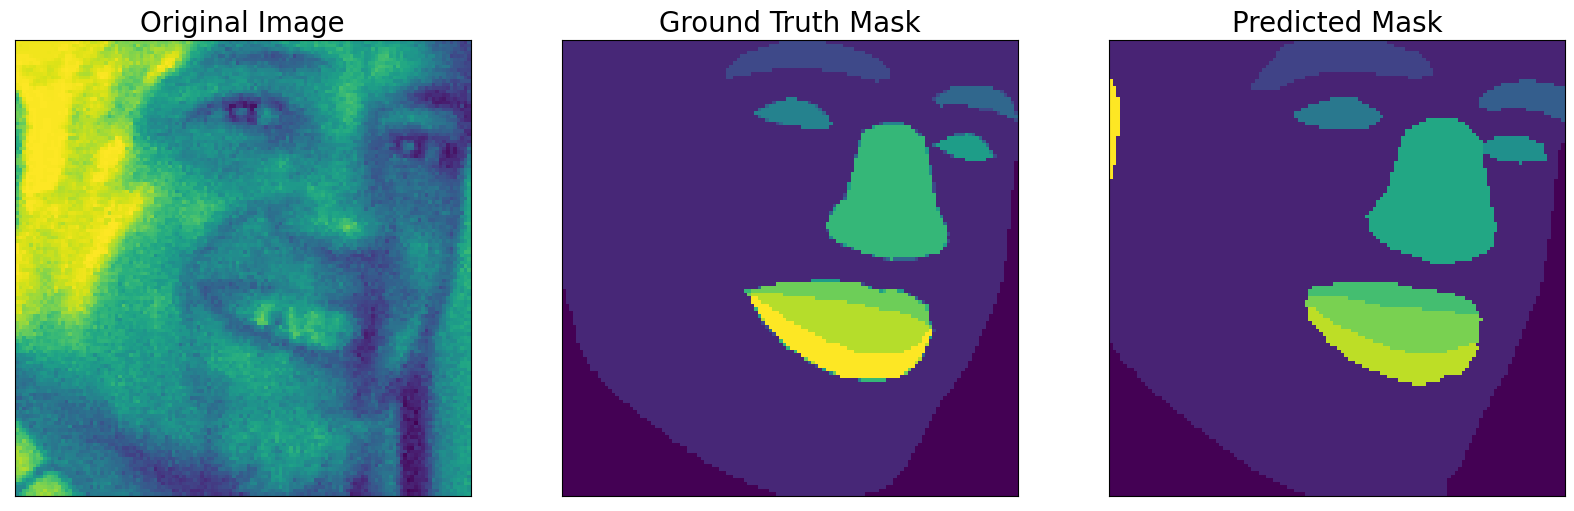

Dataset F1 =  [0.8627049  0.9601854  0.67921716 0.7130119  0.67981195 0.69790965
 0.92610455 0.770576   0.6922024  0.8035259  0.72980136]
Dataset F1 av =  0.77409554


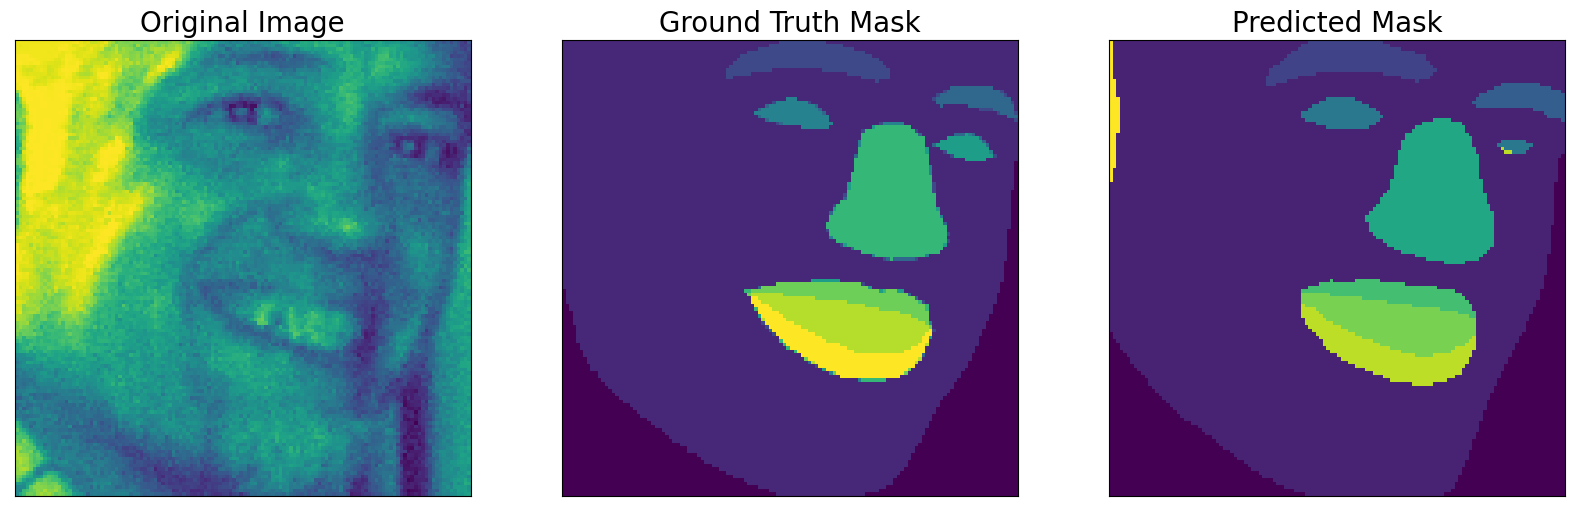

Dataset F1 =  [0.8826418  0.9634733  0.6962351  0.7237428  0.6540205  0.21038766
 0.9371017  0.7836564  0.7145659  0.82488    0.7609927 ]
Dataset F1 av =  0.7410635


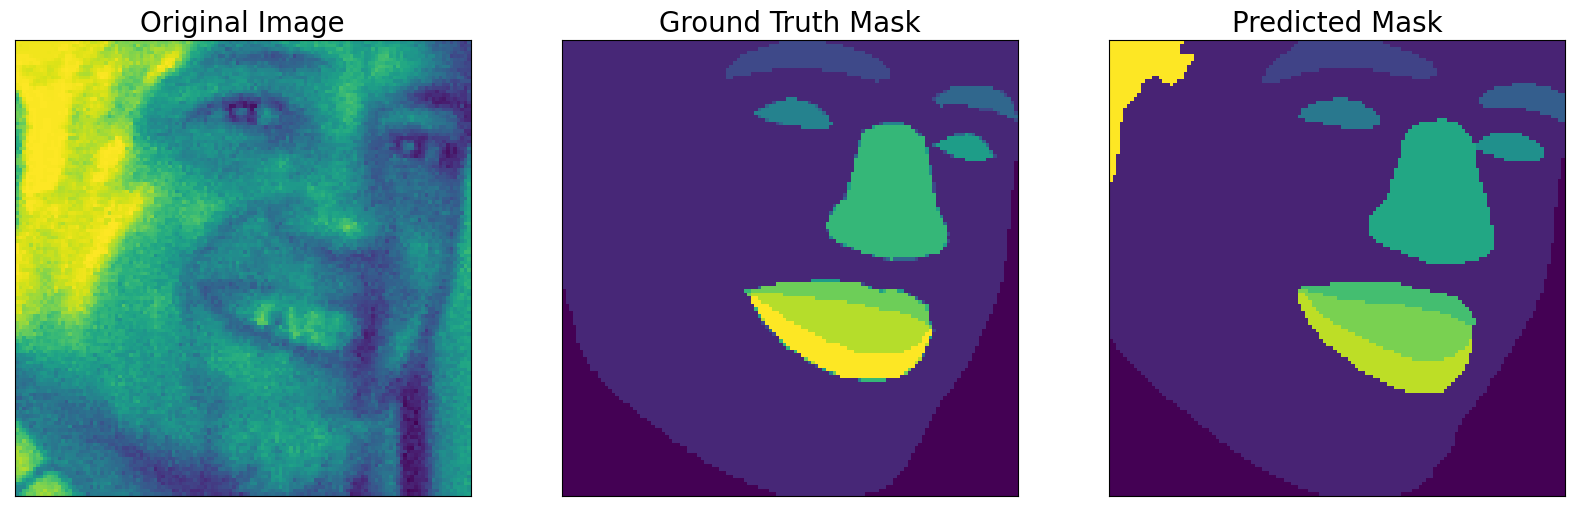

Dataset F1 =  [0.8739103  0.9667412  0.70162493 0.7303724  0.7096229  0.71612984
 0.9412175  0.7945469  0.72743386 0.8285756  0.75521547]
Dataset F1 av =  0.79503554


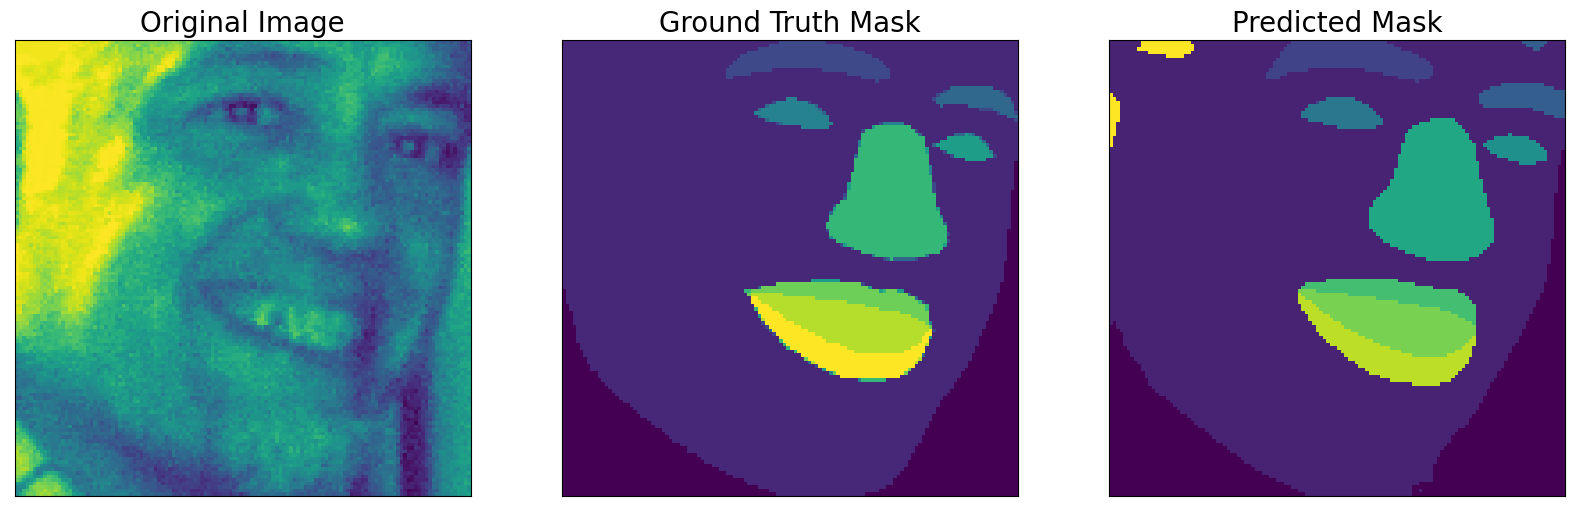

KeyboardInterrupt: 

In [15]:

print("LAPA:")

model = torch.load("/home/nathan/Documents/final_project/saved_models/lapa/deeplab.pth", map_location=DEVICE)
view_predictions(model,test_ds, num_classes)

model = torch.load("/home/nathan/Documents/final_project/saved_models/lapa/fcn.pth", map_location=DEVICE)
view_predictions(model,test_ds, num_classes)

model = torch.load("/home/nathan/Documents/final_project/saved_models/lapa/mobile.pth", map_location=DEVICE)
view_predictions(model,test_ds, num_classes)

model = torch.load("/home/nathan/Documents/final_project/saved_models/lapa/unet.pth", map_location=DEVICE)
view_predictions(model,test_ds, num_classes)



## view results after label adapting

deeplab:


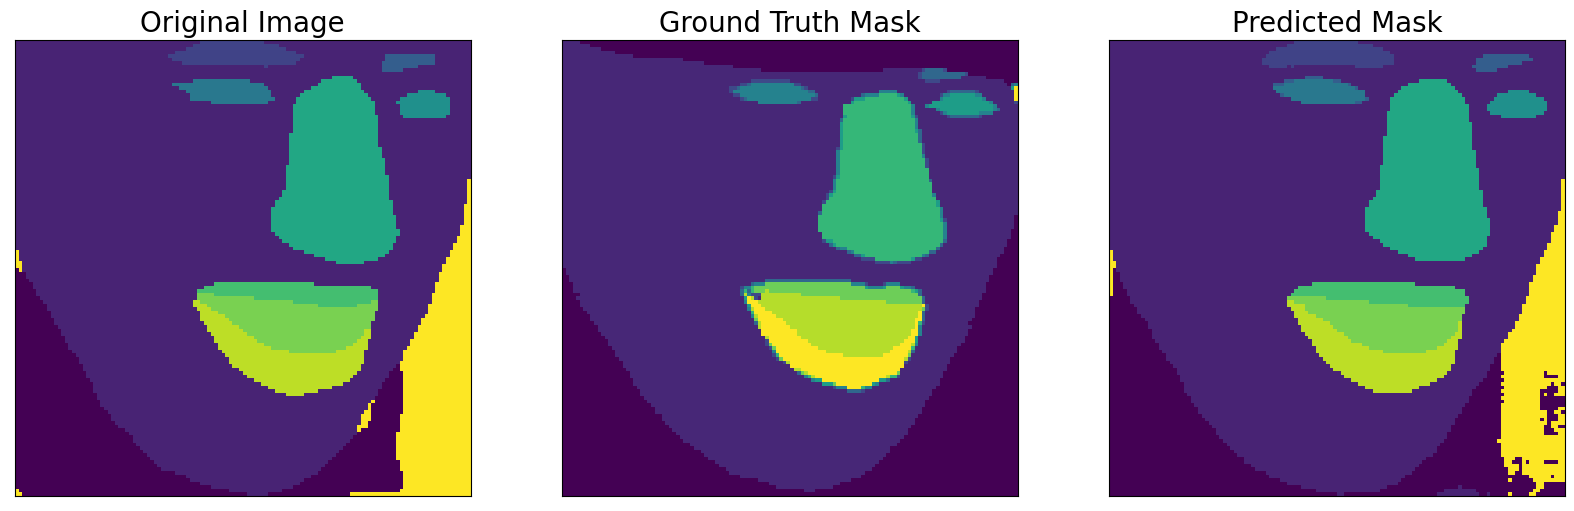

Dataset F1 =  [0.8489968  0.9579047  0.6739693  0.71313614 0.6821024  0.6904724
 0.92095023 0.7560909  0.6767841  0.8040161  0.70480984]
Dataset F1 av =  0.7662939
fpn


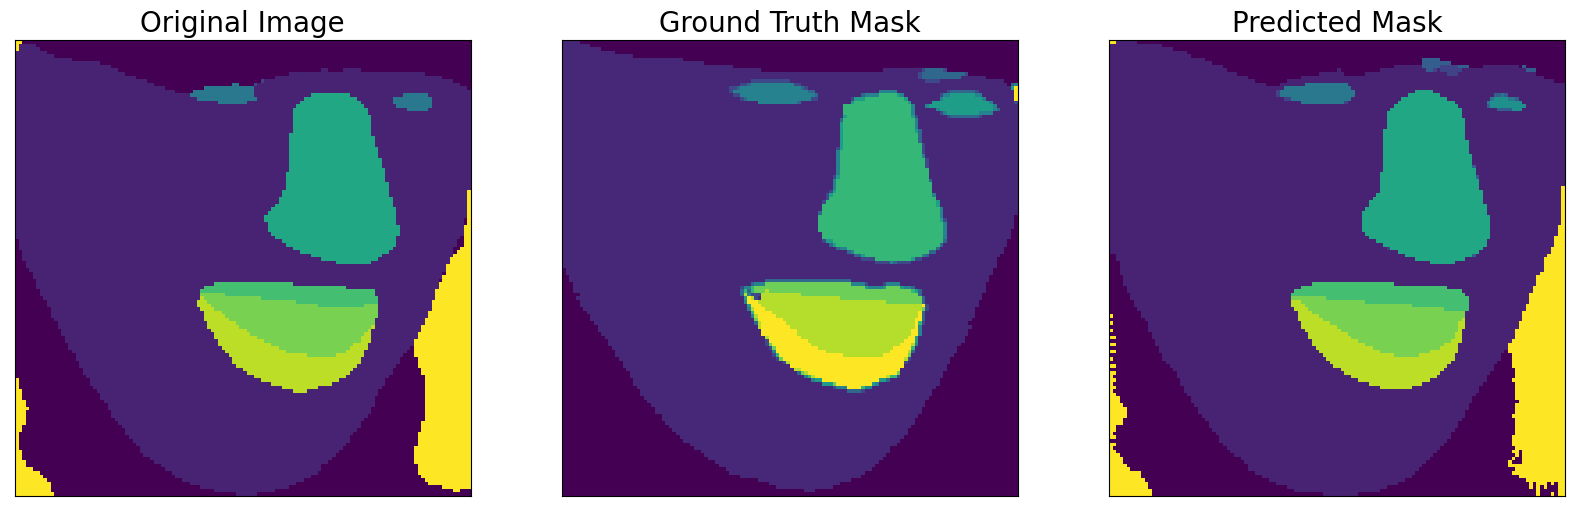

Dataset F1 =  [0.86443573 0.9600589  0.6898065  0.7152308  0.6820601  0.4377451
 0.93110996 0.75696963 0.688259   0.81776553 0.7405334 ]
Dataset F1 av =  0.7530886
mobile


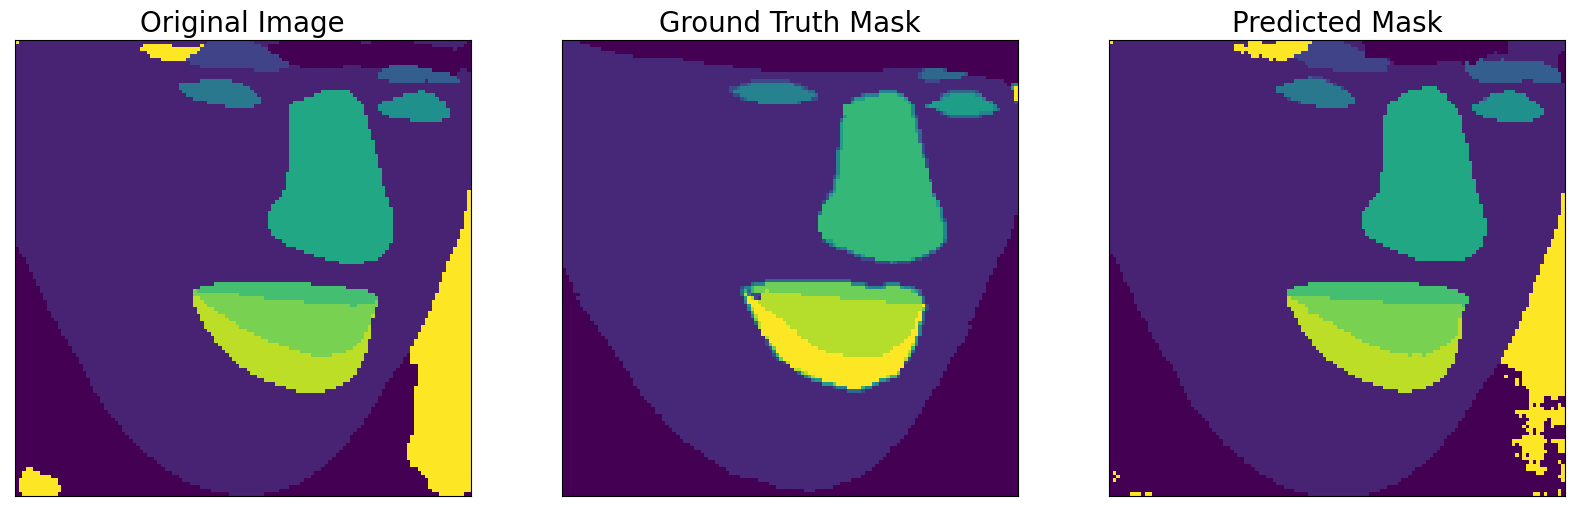

Dataset F1 =  [0.85873425 0.96286386 0.6934722  0.72513443 0.7040805  0.70047903
 0.9346946  0.7689234  0.6870288  0.8199993  0.7326527 ]
Dataset F1 av =  0.78073305
unet


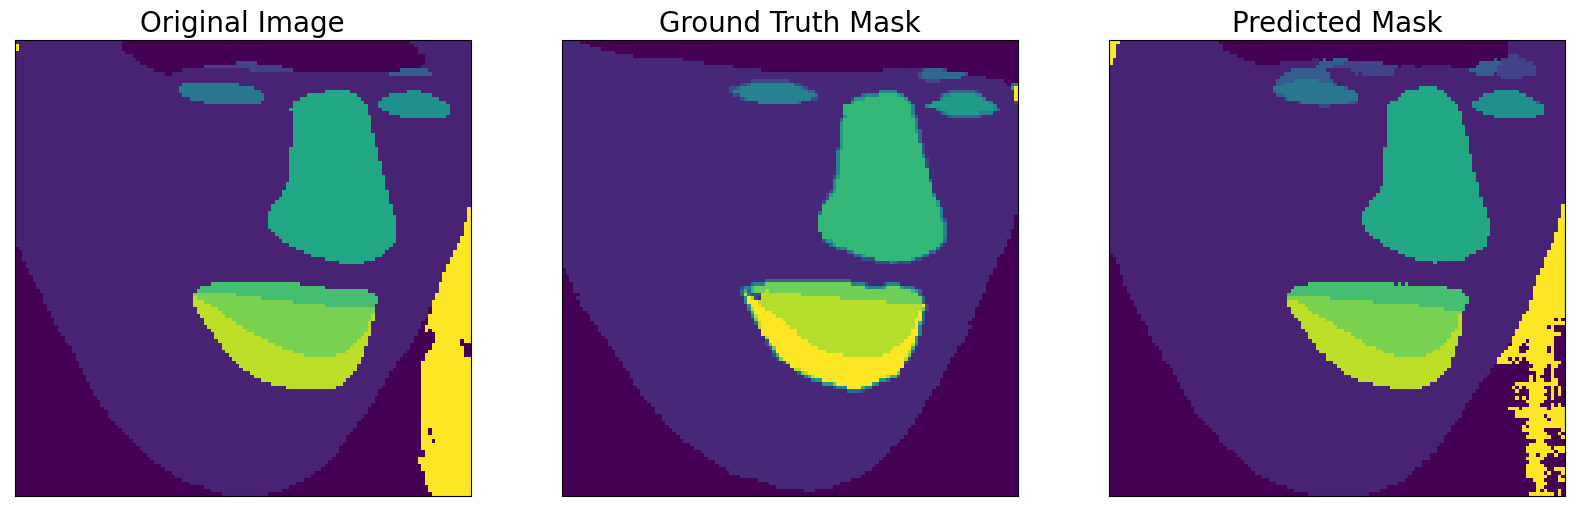

Dataset F1 =  [0.862477   0.9640497  0.6998638  0.7318479  0.70472556 0.7012968
 0.9358659  0.7705746  0.6893645  0.8286488  0.741058  ]
Dataset F1 av =  0.78452474


In [16]:
import label_test_script

print("deeplab:")
model = torch.load("/home/nathan/Documents/final_project/saved_models/lapa/deeplab.pth", map_location=DEVICE)
label_test_script.view_label_predictions(model,test_ds, num_classes)

print("fpn")
model = torch.load("/home/nathan/Documents/final_project/saved_models/lapa/fcn.pth", map_location=DEVICE)
label_test_script.view_label_predictions(model,test_ds, num_classes)

print("mobile")
model = torch.load("/home/nathan/Documents/final_project/saved_models/lapa/mobile.pth", map_location=DEVICE)
label_test_script.view_label_predictions(model,test_ds, num_classes)

print("unet")
model = torch.load("/home/nathan/Documents/final_project/saved_models/lapa/unet.pth", map_location=DEVICE)
label_test_script.view_label_predictions(model,test_ds, num_classes)